In [9]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

from copy import deepcopy
import pandas as pd

from sklearn.model_selection import ParameterGrid

import seaborn as sns

# import matplotlib as mpl
# os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'
# mpl.rcParams.update(mpl.rcParamsDefault)


In [2]:
param_grid_values = {
    'look_distance' : [0.1],
    'kernel_bandwidthLon' : [ 0.1, 0.15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75],
    'kernel_bandwidthLat' : [ 0.02, 0.04 , 0.06, .08, .1, .12],
    'n_iterations' : [20],
}

param_grid = ParameterGrid(param_grid_values)
num_cpu = 20
input_type = "confidence_map"

In [3]:
param_optim_folder2 = '../../datasets/classification/2002-2019_2/param_optimP2'

grid_image_out_dict = {}
grid_image_out_dict_stats = {}

my_len = 0

for param_idx, params in enumerate(param_grid):
    print(param_idx, params)

    out_file1 = os.path.join(param_optim_folder2, f'image_outdict_dist{params["look_distance"]}_Lon{params["kernel_bandwidthLon"]}_lat{params["kernel_bandwidthLat"]}_iter{params["n_iterations"]}.json')
    out_file2 = os.path.join(param_optim_folder2, f'image_outdictStats_dist{params["look_distance"]}_Lon{params["kernel_bandwidthLon"]}_lat{params["kernel_bandwidthLat"]}_iter{params["n_iterations"]}.json')
    
    with open(out_file1,'r') as f:
        image_out_dict = json.load(f)
    with open(out_file2,'r') as f:
        image_out_dict_stats = json.load(f)

    my_len = len(list(image_out_dict.keys()))

    grid_image_out_dict[param_idx] = deepcopy(image_out_dict)
    grid_image_out_dict_stats[param_idx] = deepcopy(image_out_dict_stats)
    
    

0 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.1, 'look_distance': 0.1, 'n_iterations': 20}
1 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.15, 'look_distance': 0.1, 'n_iterations': 20}
2 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.2, 'look_distance': 0.1, 'n_iterations': 20}
3 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.25, 'look_distance': 0.1, 'n_iterations': 20}
4 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.3, 'look_distance': 0.1, 'n_iterations': 20}
5 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.35, 'look_distance': 0.1, 'n_iterations': 20}
6 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.4, 'look_distance': 0.1, 'n_iterations': 20}
7 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.45, 'look_distance': 0.1, 'n_iterations': 20}
8 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.5, 'look_distance': 0.1, 'n_iterations': 20}
9 {'kernel_bandwidthLat': 0.02, 'kernel_bandwidthLon': 0.55, 'look_distance': 

80 {'kernel_bandwidthLat': 0.12, 'kernel_bandwidthLon': 0.6, 'look_distance': 0.1, 'n_iterations': 20}
81 {'kernel_bandwidthLat': 0.12, 'kernel_bandwidthLon': 0.65, 'look_distance': 0.1, 'n_iterations': 20}
82 {'kernel_bandwidthLat': 0.12, 'kernel_bandwidthLon': 0.7, 'look_distance': 0.1, 'n_iterations': 20}
83 {'kernel_bandwidthLat': 0.12, 'kernel_bandwidthLon': 0.75, 'look_distance': 0.1, 'n_iterations': 20}


In [4]:
import collections
from collections import Counter

cur_out_stats = {
            # General info
            'num_DB_groups':0,
            'num_MS_groups':0,

            'matches':0,

            # MS with DB matching info
            'unmatched_db':0,
            'multiDB_singleMS': 0,
            'db_too_far':0,


            'unmatched_ms':0,
            'bad_ms':0,
            'ms_too_far':0,

            "ious":0,
            "distances":0

    }

stats_keys = cur_out_stats.keys()

should_check =  list(stats_keys) + [
                                        'num_rejects_all',
                                        'num_optimizable_rejects',
                                        'rate_optimizable_rejects',
                                    ]

gridsearch_dict_per_img = { k : np.zeros((len(param_grid_values['kernel_bandwidthLon']), 
                                   len(param_grid_values['kernel_bandwidthLat']),
                                      my_len
                                   ))
                    for k in should_check}

should_check_global = list(stats_keys) + [
                                            'num_rejects_all',
                                            'num_optimizable_rejects',
                                            'rate_optimizable_rejects',
                                         ]
gridsearch_dict_total = { k : np.zeros((len(param_grid_values['kernel_bandwidthLon']), 
                                   len(param_grid_values['kernel_bandwidthLat'])
                                   ))
                    for k in should_check_global}

grid_search_reject_distribs = {}


for param_idx, params in enumerate(param_grid):
#     param_idx= str(param_idx)
    image_out_dict = grid_image_out_dict[param_idx]
    image_out_dict_stats = grid_image_out_dict_stats[param_idx]
    
    # General info
    num_DB_groups_per_image = np.array([item['num_DB_groups'] for k,item in image_out_dict_stats.items()])
    num_MS_groups_per_image = np.array([item['num_MS_groups'] for k,item in image_out_dict_stats.items()])

    diff_num_groups = num_DB_groups_per_image - num_MS_groups_per_image # should be shown on histogram , closer to 0 is better


    # matches
    num_MSmatchesDB = np.array([ np.sum(np.array(v['matches'])>-1) for k,v in image_out_dict_stats.items()])
    
    num_unmatched_db = np.array([len(v['unmatched_db']) for k,v in image_out_dict_stats.items()])
    num_multiDB_singleMS = np.array([len(v['multiDB_singleMS']) for k,v in image_out_dict_stats.items()])
    num_db_too_far = np.array([len(v['db_too_far']) for k,v in image_out_dict_stats.items()])


    num_unmatchedMS = np.array([len(v['unmatched_ms']) for k,v in image_out_dict_stats.items()])
    num_badMS = np.array([len(v['bad_ms']) for k,v in image_out_dict_stats.items()])
    num_ms_too_far = np.array([len(v['ms_too_far']) for k,v in image_out_dict_stats.items()])
    
  
    num_optimizable_rejects = num_badMS + num_multiDB_singleMS 
    num_rejects_all = num_optimizable_rejects + num_db_too_far

    # get indices of current params
    kernel_bandwidthLon_idx = param_grid_values['kernel_bandwidthLon'].index(params['kernel_bandwidthLon'])
    kernel_bandwidthLat_idx = param_grid_values['kernel_bandwidthLat'].index(params['kernel_bandwidthLat'])
    ############################
    # Fill per-image dictinnary 
    ############################

    # number of DB groups
    gridsearch_dict_per_img['num_DB_groups'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_DB_groups_per_image
    # number of MS groups
    gridsearch_dict_per_img['num_MS_groups'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_MS_groups_per_image

    # number of matches
    # print(num_MSmatchesDB.shape)
    # print(num_MSmatchesDB)
    gridsearch_dict_per_img['matches'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_MSmatchesDB
    # number of unmatched DB groups
    gridsearch_dict_per_img['unmatched_db'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_unmatched_db
    # number of multi DB groups matched to single MS group
    gridsearch_dict_per_img['multiDB_singleMS'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_multiDB_singleMS
    # number of DB groups too far from MS group
    gridsearch_dict_per_img['db_too_far'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_db_too_far
    # number of unmatched MS groups
    gridsearch_dict_per_img['unmatched_ms'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_unmatchedMS
    # number of bad MS groups
    gridsearch_dict_per_img['bad_ms'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_badMS
    # number of MS groups too far from DB group
    gridsearch_dict_per_img['ms_too_far'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_ms_too_far


    gridsearch_dict_per_img['num_optimizable_rejects'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_optimizable_rejects
    gridsearch_dict_per_img['num_rejects_all'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = num_rejects_all
     
    ############################
    # Fill total dictionnary
    ############################
    # number of DB groups
    gridsearch_dict_total['num_DB_groups'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_DB_groups_per_image)
    # number of MS groups
    gridsearch_dict_total['num_MS_groups'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_MS_groups_per_image)

    # number of matches
    gridsearch_dict_total['matches'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_MSmatchesDB)
    # number of unmatched DB groups
    gridsearch_dict_total['unmatched_db'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_unmatched_db)
    # number of multi DB groups matched to single MS group
    gridsearch_dict_total['multiDB_singleMS'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_multiDB_singleMS)
    # number of DB groups too far from MS group
    gridsearch_dict_total['db_too_far'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_db_too_far)
    # number of unmatched MS groups
    gridsearch_dict_total['unmatched_ms'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_unmatchedMS)
    # number of bad MS groups
    gridsearch_dict_total['bad_ms'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_badMS)
    # number of MS groups too far from DB group
    gridsearch_dict_total['ms_too_far'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_ms_too_far)
    
    

    gridsearch_dict_total['num_optimizable_rejects'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_optimizable_rejects)
    gridsearch_dict_total['num_rejects_all'][kernel_bandwidthLon_idx,kernel_bandwidthLat_idx] = np.sum(num_rejects_all)

#     break
    


In [5]:
%matplotlib ipympl

plt.rcParams.update({'font.size': 10})
plt.rcParams['text.usetex'] = False

# accuracy
# all_isolated = gridsearch_dict_total['num_DB_isolated_groups'] 
# all_overlapping = gridsearch_dict_total['num_DB_overlaping_bboxes'] 

# print('all_isolated: ', all_isolated[0,0],'all_overlapping: ' ,all_overlapping[0,0])
# all_noMS_but_DB = gridsearch_dict_total['num_noMS_but_DB_reject']

all_groups = gridsearch_dict_total['num_DB_groups']

# print(all_groups)

all_too_far = gridsearch_dict_total['db_too_far']

to_count = all_groups - all_too_far

all_optimizable_rejects = gridsearch_dict_total['num_optimizable_rejects']

all_matches = gridsearch_dict_total['matches']

all_badMS = gridsearch_dict_total['bad_ms']

all_unmatched_ms = gridsearch_dict_total['unmatched_ms']
all_ms_too_far = gridsearch_dict_total['ms_too_far']


all_unmatched_db = gridsearch_dict_total['unmatched_db']
all_db_too_far = gridsearch_dict_total['db_too_far']


# Compute Accuracy

### version 1:
## Acc = $\frac{Matches}{Matches + Errors}$

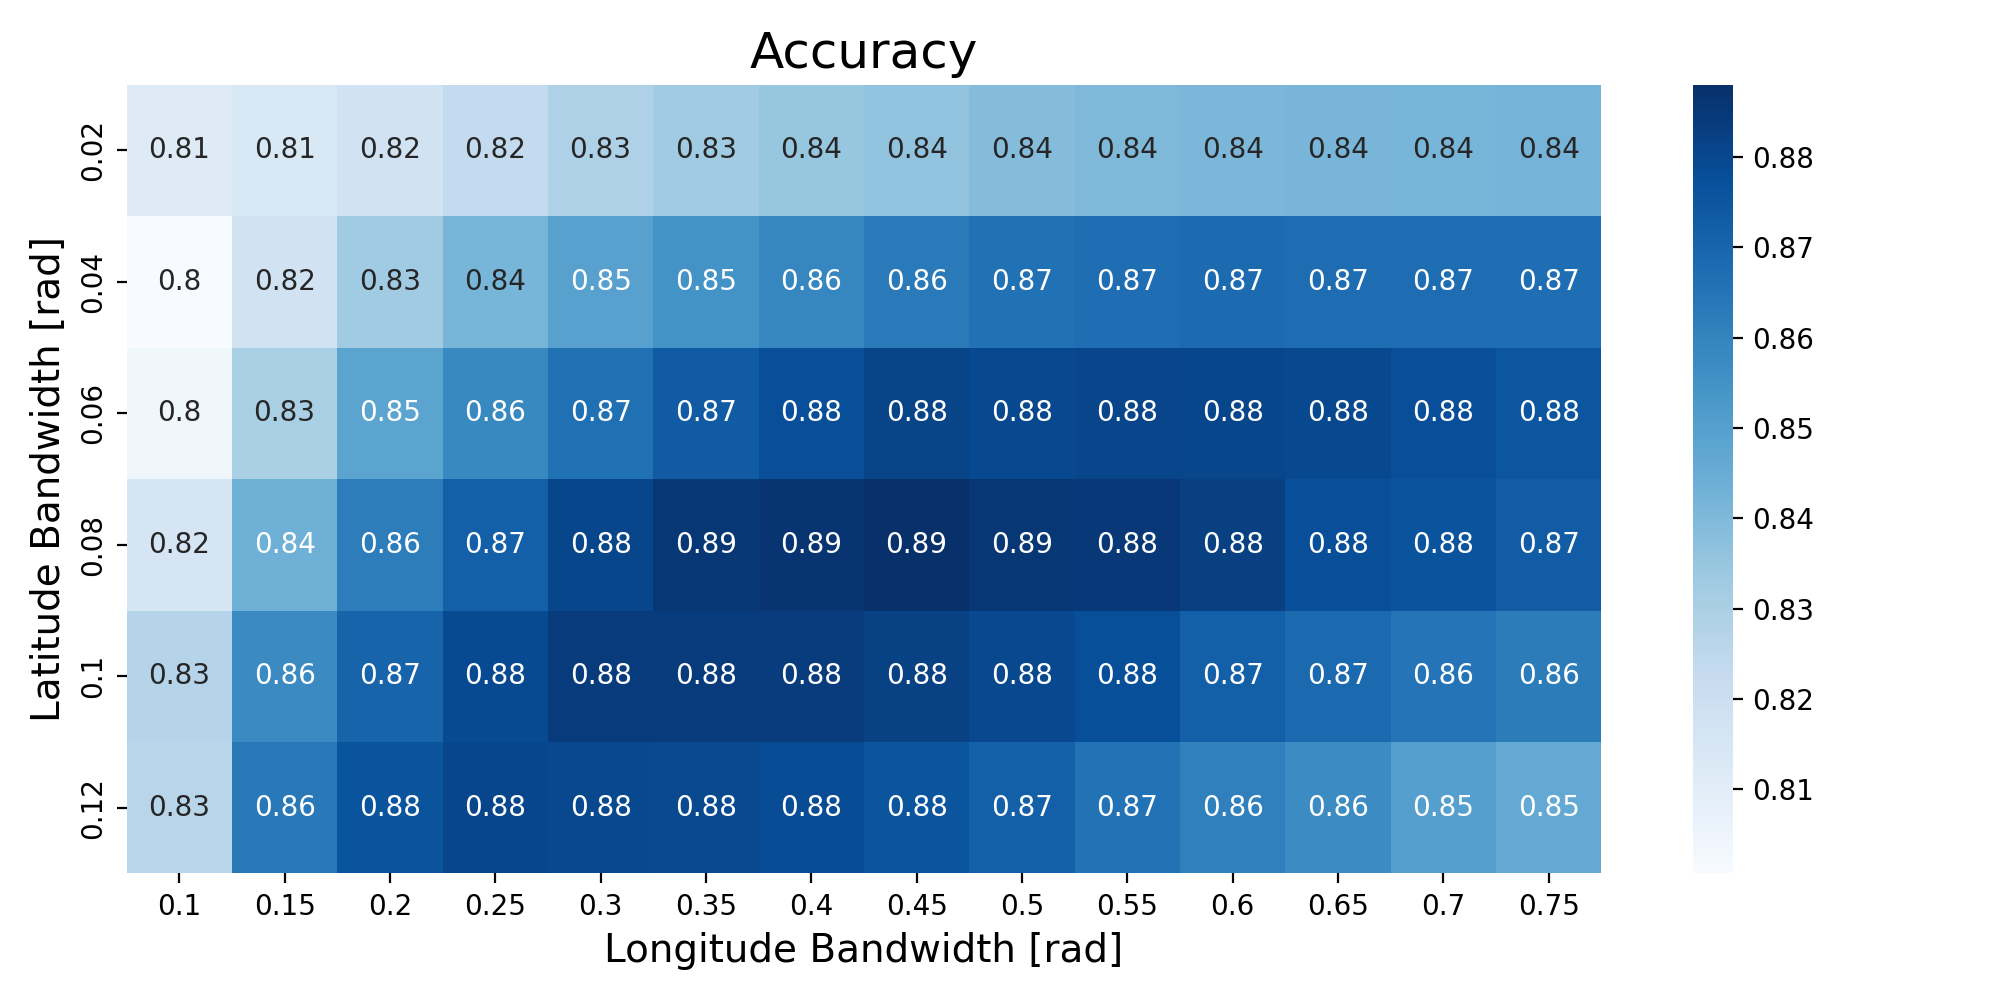

In [6]:
########################################################################################################################

accuracy = all_matches / (all_matches + all_optimizable_rejects )

accuracy_df = pd.DataFrame(accuracy)
accuracy_df.columns = param_grid_values['kernel_bandwidthLat']
accuracy_df.index = param_grid_values['kernel_bandwidthLon']
accuracy_df = accuracy_df.transpose()


fig_, ax_ = plt.subplots(1,1, figsize=(10*1,5*1), dpi=200)
# ax_ = sns.heatmap(accuracy_df, ax=ax_, annot=True, cmap=plt.cm.Blues.reversed()) # Paper submission 1
ax_ = sns.heatmap(accuracy_df, ax=ax_, annot=True, cmap=plt.cm.Blues)
# ax_ = sns.heatmap(accuracy_df, ax=ax_, vmin=0, annot=True)
ax_.set_title('Accuracy', fontsize=18)
# ax_.set_ylabel('kernel_bandwidthLat')
# ax_.set_xlabel('kernel_bandwidthLon')
ax_.set_ylabel('Latitude Bandwidth [rad]', fontsize=14)
ax_.set_xlabel('Longitude Bandwidth [rad]', fontsize=14)

# #remove colorbar
# cbar = ax_.collections[0].colorbar
# cbar.remove()

fig_.tight_layout()


### version 2:
## Acc = $\frac{Matches}{Matches + Errors + (U_{MS} - U_{MStooFar})}$

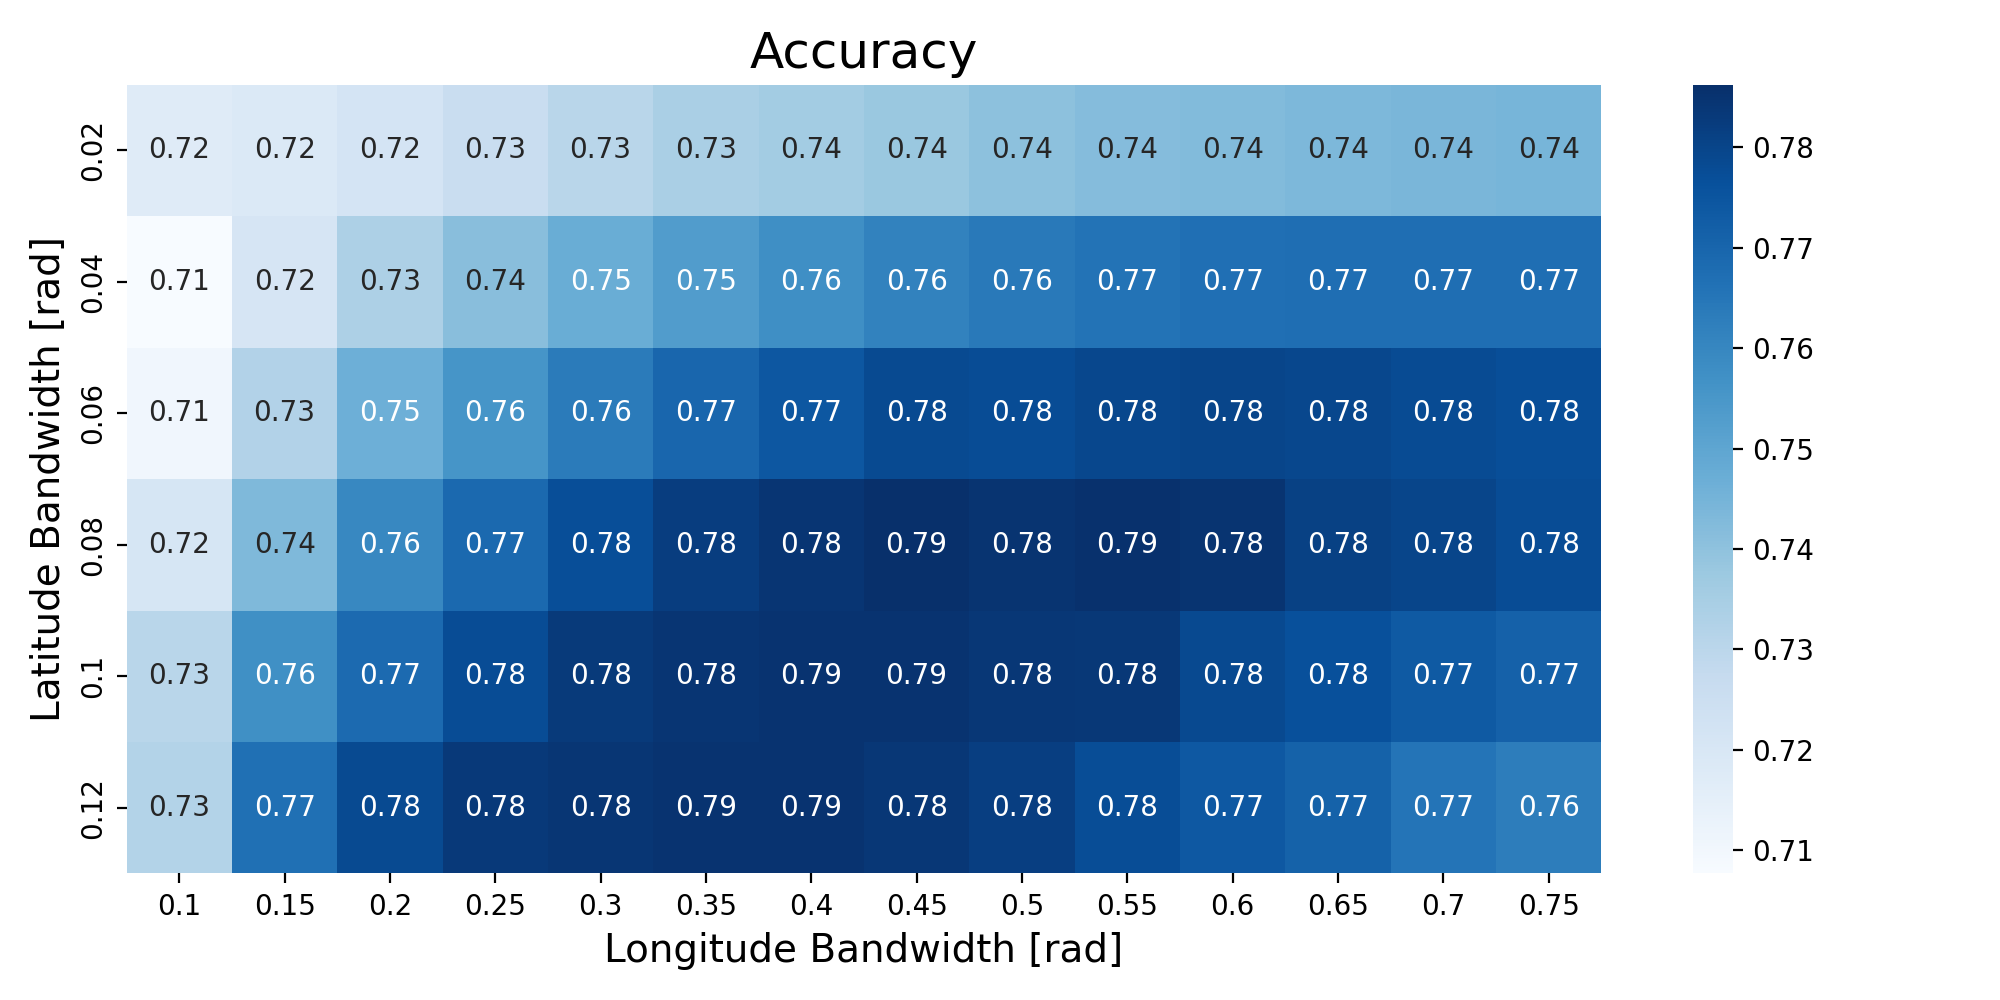

In [7]:

########################################################################################################################

accuracy = all_matches / (all_matches + all_optimizable_rejects + (all_unmatched_ms - all_ms_too_far)  )
accuracy_df = pd.DataFrame(accuracy)
accuracy_df.columns = param_grid_values['kernel_bandwidthLat']
accuracy_df.index = param_grid_values['kernel_bandwidthLon']
accuracy_df = accuracy_df.transpose()

fig2_, ax2_ = plt.subplots(1,1, figsize=(10*1,5*1),dpi=200)
# ax2_ = sns.heatmap(accuracy_df, ax=ax2_, annot=True, cmap=plt.cm.Blues.reversed()) # Paper submission 1
ax2_ = sns.heatmap(accuracy_df, ax=ax2_, annot=True,  cmap=plt.cm.Blues)
# ax2_ = sns.heatmap(accuracy_df, ax=ax_, vmin=0, annot=True)
ax2_.set_title('Accuracy', fontsize=18)
# ax2_.set_ylabel('kernel_bandwidthLat')
# ax2_.set_xlabel('kernel_bandwidthLon')
ax2_.set_ylabel('Latitude Bandwidth [rad]', fontsize=14)
ax2_.set_xlabel('Longitude Bandwidth [rad]', fontsize=14)
# #remove colorbar
# cbar = ax2_.collections[0].colorbar
# cbar.remove()

fig2_.tight_layout()


########################################################################################################################


### version 3 (PAPER)
## Acc = $\frac{Matches}{Matches + (U_{db} - I_{db} ) + (U_{M} - I_{M})}$

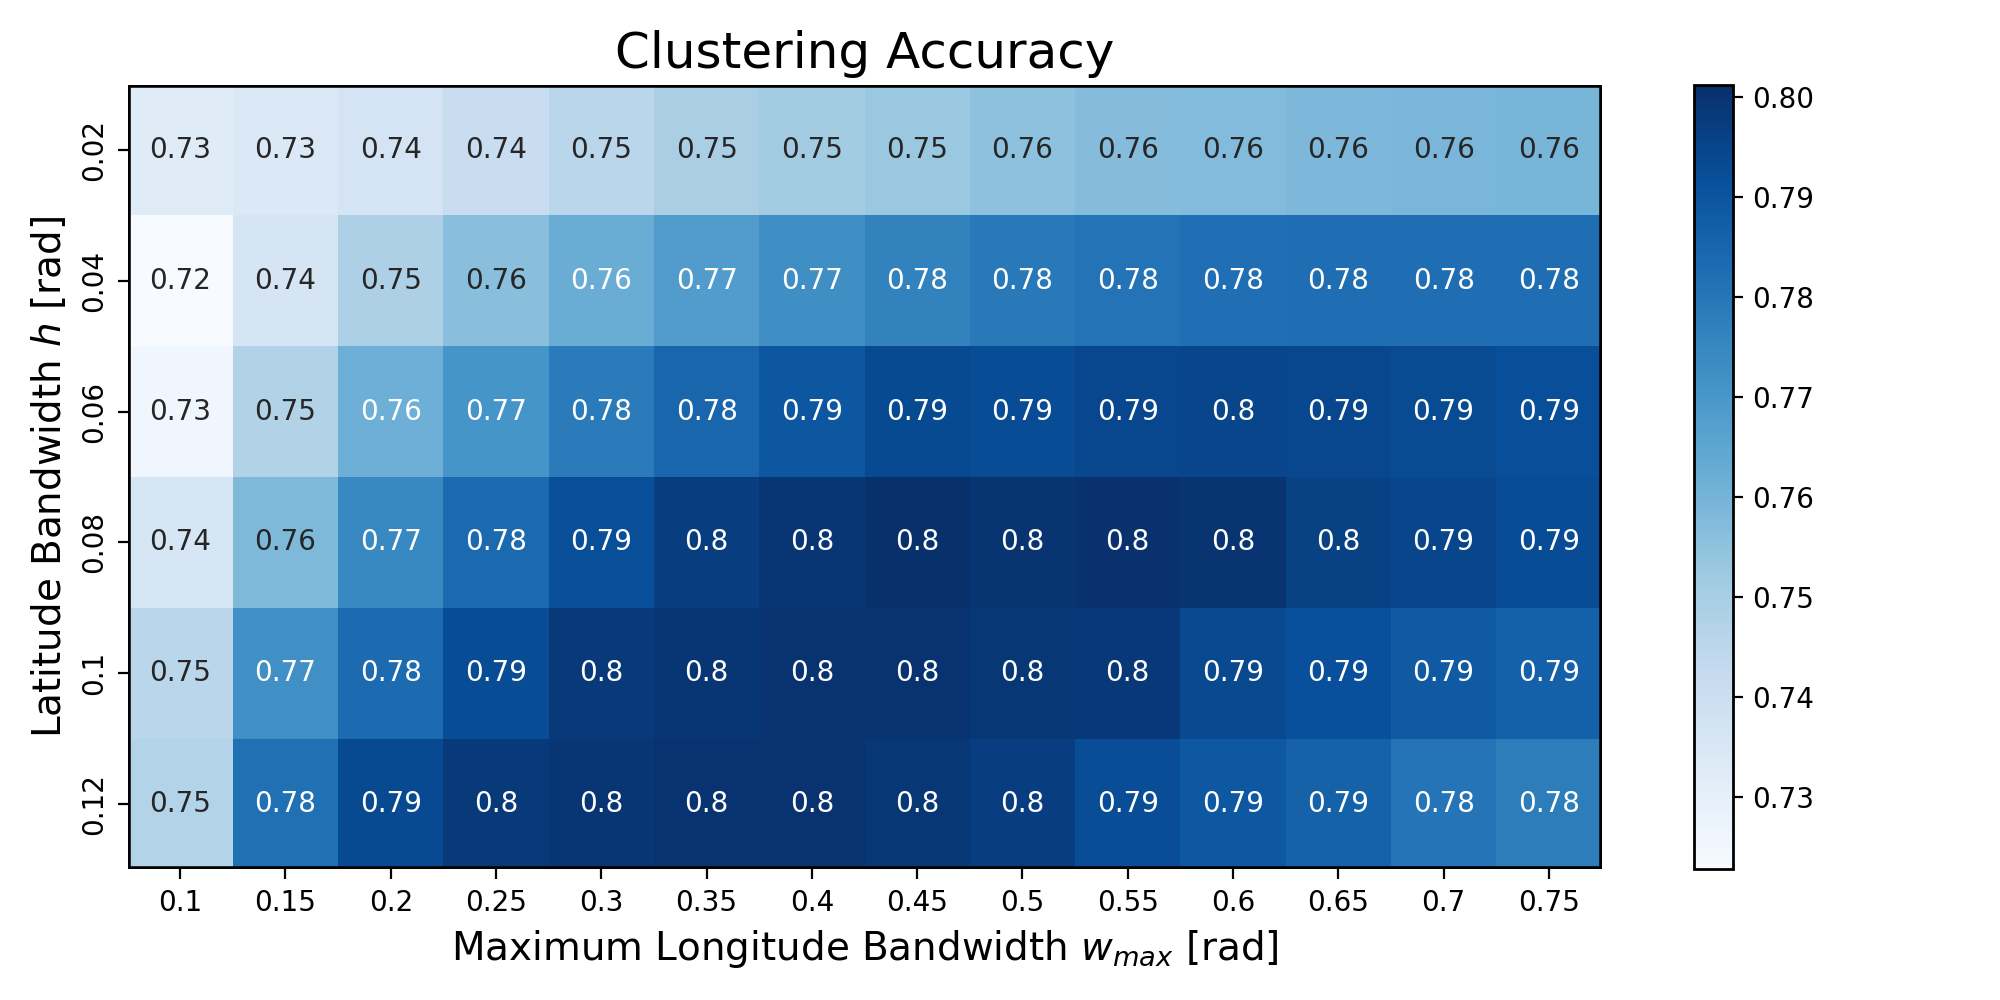

In [10]:
accuracy = all_matches / (all_matches + (all_unmatched_db - all_db_too_far) + (all_unmatched_ms + all_badMS - all_ms_too_far)  )
accuracy_df = pd.DataFrame(accuracy)
accuracy_df.columns = param_grid_values['kernel_bandwidthLat']
accuracy_df.index = param_grid_values['kernel_bandwidthLon']
accuracy_df = accuracy_df.transpose()

fig3_, ax3_ = plt.subplots(1,1, figsize=(10*1,5*1),dpi=200)
# ax3_ = sns.heatmap(accuracy_df, ax=ax3_, annot=True, cmap=plt.cm.Blues)
ax3_ = sns.heatmap(accuracy_df+0.015, ax=ax3_, annot=True, cmap=plt.cm.Blues)
ax3_.set_title('Clustering Accuracy', fontsize=18)
# ax3_.set_ylabel('kernel_bandwidthLat')
# ax3_.set_xlabel('kernel_bandwidthLon')
ax3_.set_ylabel(r'Latitude Bandwidth $h$ [rad]', fontsize=14)
ax3_.set_xlabel(r'Maximum Longitude Bandwidth $w_{max}$ [rad]', fontsize=14)

# Drawing the frame
ax3_.axhline(y = 0, color='k',linewidth = 2)
ax3_.axvline(x = 0, color = 'k',linewidth = 2)
ax3_.axhline(y = accuracy_df.shape[0], color = 'k',linewidth = 2)  
ax3_.axvline(x = accuracy_df.shape[1], color = 'k', linewidth = 2)

cbar = ax3_.collections[0].colorbar
cbar.outline.set_color('black')
cbar.outline.set_linewidth(1)
# #remove colorbar
# cbar.remove()
fig3_.tight_layout()
# fig3_.savefig('clustering_accuracy.pdf', format='pdf',  bbox_inches='tight', dpi=300)

########################################################################################################################
